In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
polarities = pd.read_csv("./polarities.csv").dropna()
polarities.head()

,Unnamed: 0,tweet_id,tweet_text,user/name,user_id,n_tweets,flagged,pol_rightness,credibility,moderacy
0,0,1346674133111865347,The steal is in the making in Georgia. Wait fo...,TomiLahren,1276954908848197633,198,True,0.46,2.00,1.80
1,1,1346674133111865347,The steal is in the making in Georgia. Wait fo...,TomiLahren,1333031903725686785,3101,True,-0.31,2.00,1.93
2,2,1346674133111865347,The steal is in the making in Georgia. Wait fo...,TomiLahren,984139126558539776,2743,True,-0.16,2.01,1.83
3,3,1346674133111865347,The steal is in the making in Georgia. Wait fo...,TomiLahren,888424614732353536,1231,True,0.50,2.04,1.99
4,4,1346674133111865347,The steal is in the making in Georgia. Wait fo...,TomiLahren,1034539618472013825,2628,True,0.11,2.01,1.64


In [3]:
polarities['user/name'].unique()

array(['TomiLahren', 'EricTrump', 'AdamLaxalt', 'DonaldJTrumpJr',
       'MariaBartiromo', 'RudyGiuliani', 'Paduch'], dtype=object)

In [4]:
polarities['flagged'].value_counts()

True     343
False    326
Name: flagged, dtype: int64

### Exploratory Analysis

In [5]:
data = polarities[['flagged', 'pol_rightness', 'credibility', 'moderacy']]
data.describe()

,pol_rightness,credibility,moderacy
count,669.000000,669.000000,669.000000
mean,-0.093797,2.011286,1.872422
std,0.501687,0.019959,0.195158
min,-1.160000,1.990000,1.140000
25%,-0.430000,2.000000,1.810000
50%,-0.170000,2.000000,1.910000
75%,0.110000,2.010000,1.950000
max,2.730000,2.150000,2.820000


In [6]:
data.head()

,flagged,pol_rightness,credibility,moderacy
0,True,0.46,2.00,1.80
1,True,-0.31,2.00,1.93
2,True,-0.16,2.01,1.83
3,True,0.50,2.04,1.99
4,True,0.11,2.01,1.64


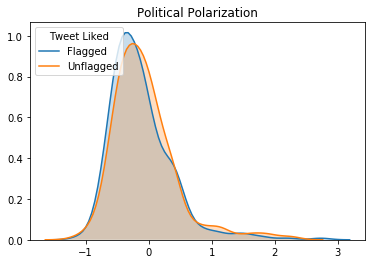

In [7]:
pol_flagged = data[data['flagged']]['pol_rightness']
pol_unflagged = data[data['flagged'] == False]['pol_rightness']
sns.kdeplot(pol_flagged, shade=True).set_title("Political Polarization")
sns.kdeplot(pol_unflagged, shade=True)
plt.legend(title='Tweet Liked', loc='upper left', labels=['Flagged', 'Unflagged'])
plt.savefig("political_kde.png")

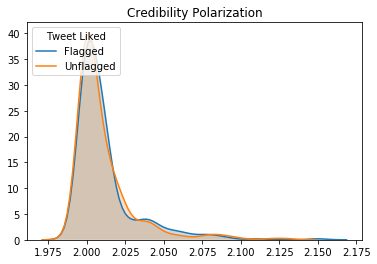

In [8]:
pol_flagged = data[data['flagged']]['credibility']
pol_unflagged = data[data['flagged'] == False]['credibility']
sns.kdeplot(pol_flagged, shade=True).set_title("Credibility Polarization")
sns.kdeplot(pol_unflagged, shade=True)
plt.legend(title='Tweet Liked', loc='upper left', labels=['Flagged', 'Unflagged'])

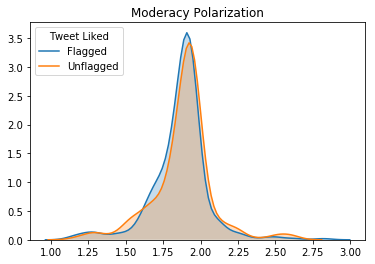

In [9]:
pol_flagged = data[data['flagged']]['moderacy']
pol_unflagged = data[data['flagged'] == False]['moderacy']
sns.kdeplot(pol_flagged, shade=True).set_title("Moderacy Polarization")
sns.kdeplot(pol_unflagged, shade=True)
plt.legend(title='Tweet Liked', loc='upper left', labels=['Flagged', 'Unflagged'])

### Examining Correlation  
This section looks at whether there is a quantifiable and/or visual correlation between each of the three dimensions. Each of the below plots is made up of points, each one representing a user. The color of the point indicates whether that user was one who retweeted a flagged tweet or an unflagged tweet.

**Political vs Credibility**

Text(0.5,1,'User Political verus Credibility Polarity')

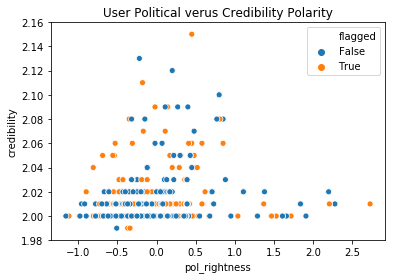

In [10]:
data = polarities[['pol_rightness', 'credibility']]
sns.scatterplot(x=data['pol_rightness'], y=data['credibility'],
                hue=polarities['flagged']).set_title("User Political verus Credibility Polarity")

In [11]:
print("Correlation Matrix")
print(data.corr())

Correlation Matrix
               pol_rightness  credibility
pol_rightness       1.000000     0.200394
credibility         0.200394     1.000000


**Political vs Moderacy**

Text(0.5,1,'User Political vs Moderacy Polarity')

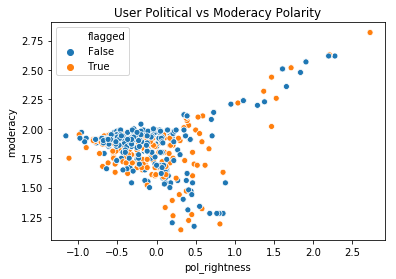

In [12]:
data = polarities[['pol_rightness', 'moderacy']]
sns.scatterplot(x=data['pol_rightness'], y=data['moderacy'],
                hue=polarities['flagged']).set_title("User Political vs Moderacy Polarity")

In [13]:
print("Correlation Matrix")
print(data.corr())

Correlation Matrix
               pol_rightness  moderacy
pol_rightness       1.000000  0.242497
moderacy            0.242497  1.000000


**Moderacy vs Credibility**

Text(0.5,1,'User Credibility verus Moderacy Polarity')

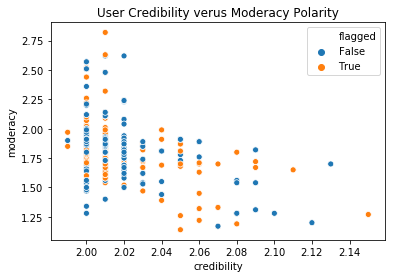

In [14]:
data = polarities[['moderacy', 'credibility']]
sns.scatterplot(x=data['credibility'], y=data['moderacy'],
                hue=polarities['flagged']).set_title("User Credibility verus Moderacy Polarity")

In [15]:
print("Correlation Matrix")
print(data.corr())

Correlation Matrix
             moderacy  credibility
moderacy     1.000000    -0.502355
credibility -0.502355     1.000000


### Test 1
I will perform a permutation test for each dimension. That is, for one dimension I will calculate the difference between the sample means for all polarity scores for the flagged tweets group and then for the unflagged tweets groups. I will define the test statistic as the difference between those two means. I will then shuffle the flagged/unflagged labels and then recalculate the statistic. I will do this 100 times then calculate the p value.  
  
**Permutation Test:**  
  
Test Statistic: Define the test statistic as the difference between the sample means for the flagged and unflagged group for one dimension  
  
Null Hypothesis: There is no difference in the polarity scores between the flagged and unflagged groups  
  
Alternative Hypothesis: The flagged users have a higher polarity score in a respective dimension than the unflagged users

In [16]:
# Defining functions for use in permutation test
def mean_diff(data, dim):
    return np.mean(data[data['flagged'] == True][dim]) - np.mean(data[data['flagged'] == False][dim])

def permutation_test(data, n_reps, dim):
    # Observed statistic
    obs = mean_diff(data, dim)
    print("Observed Mean: " + str(np.mean(data[dim])))
    
    # Running and permuting n_reps of the data
    trials = []
    for i in range(n_reps):
        shuffled_impres = (
            data['flagged']
            .sample(replace=False, frac=1)
            .reset_index(drop=True)
        )
        shuffled = (
            data
            .assign(**{'flagged': shuffled_impres})
        )
        trials.append(mean_diff(shuffled, dim))
    return np.count_nonzero(np.array(trials) >= obs) / n_reps

In [18]:
# First let's run the test for the political polarity
data = polarities[['pol_rightness', 'credibility', 'moderacy', 'flagged']]
outcomes = []
dimensions = ['pol_rightness', 'credibility', 'moderacy']
for dim in dimensions:
    out = {'Dimension': dim, 
           'p-value': permutation_test(data, 1000, dim)}
    outcomes.append(out)
    print(out)
    print("\n")
with open('./test.json', 'w') as fout:
    json.dump(outcomes , fout)

Observed Mean: -0.09379671150971605
{'Dimension': 'pol_rightness', 'p-value': 0.945}


Observed Mean: 2.0112855007473778
{'Dimension': 'credibility', 'p-value': 0.315}


Observed Mean: 1.872421524663679
{'Dimension': 'moderacy', 'p-value': 0.899}




**Evaluating:**  
The break down of the tests for each dimension is reported above. Notice that for the credibility and the moderacy dimensions, there is a more significant difference between the two groups than there is for the poltical dimension. Hopefully with more data this becomes more apparent. 

### Test 2
We will compare the data for each dimension using a t-test. Under this test we assume the data is normally distributed with the same variance. We will perform a two-sided test between the flagged and unflagged group for each dimension.  
  
**Two-sided t-test**  

In [19]:
outcomes = []
for dim in dimensions:
    flagged = data[data['flagged'] == True][dim]
    unflagged = data[data['flagged'] == False][dim]
    out = {'Dimension': dim, 
           'Results': stats.ttest_ind(flagged, unflagged, equal_var=True)}
    outcomes.append(out)
outcomes

[{'Dimension': 'pol_rightness',
  'Results': Ttest_indResult(statistic=-1.5445782390461946, pvalue=0.12292260950534312)},
 {'Dimension': 'credibility',
  'Results': Ttest_indResult(statistic=0.4999421704837653, pvalue=0.6172806854906729)},
 {'Dimension': 'moderacy',
  'Results': Ttest_indResult(statistic=-1.2691073275979001, pvalue=0.2048454575958873)}]

**Outcome** 
We can see a very similar outcome as the permutation test, as we would expect. Next we will test the one-sided t-test for both groups

### Test 3
We will test whether flagged group has statistically significantly higher or lower polarity scores than the unflagged group for both dimensions. We will use a one-sided t-test.  
**One-sided t-test**

In [20]:
outcomes = []
for dim in dimensions:
    flagged = data[data['flagged'] == True][dim]
    unflagged = data[data['flagged'] == False][dim]
    gen = stats.ttest_ind(flagged, unflagged, equal_var=True)
    out = {'Dimension': dim,
           'p-value': gen[1]/2,
           'Test Statistic': gen[0]
          }
    outcomes.append(out)
outcomes

[{'Dimension': 'pol_rightness',
  'p-value': 0.06146130475267156,
  'Test Statistic': -1.5445782390461946},
 {'Dimension': 'credibility',
  'p-value': 0.30864034274533647,
  'Test Statistic': 0.4999421704837653},
 {'Dimension': 'moderacy',
  'p-value': 0.10242272879794365,
  'Test Statistic': -1.2691073275979001}]

**Outcome**  
First, let alpha = 0.1. Next, we can derive the outcome of the one-sided as the flagged polarities are significantly greater than the unflagged polarities if the p-value < alpha and the test statistic is > 0. Likewise if the test statistic is < 0 then it means the flagged polarities are significantly lesser than the unflagged polarities. Notice here that while there is no statistically significant outcome for the moderacy and credibility dimensions, we can see that the political polarity of users who retweeted a flagged tweet is statistically significantly greater than those of the users who retweeted an unflagged tweet. This is what we would expect since the tweets being flagged are coming from a user who is generally aligned with right wing views so the users that are interacting with a flagged tweet tend to have a higher polarity tending towards the right.  